In [93]:
import numpy as np
from matplotlib import pyplot as plt

In [94]:
def get_dist(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def get_vect(x1, y1, x2, y2):
    return np.array([[x2-x1],[y2-y1]])

# return the homogenous form of vector x
# vector x must be series of 2D vectors
def h(x):
    if len(np.shape(x)) == 2 and np.shape(x)[0] == 2:
        return np.vstack([x, np.ones(np.shape(x)[1])])
    else:
        raise ValueError("Input to homogenous function must be series of 2D vectors")
    
# return the 2D form of homogenous vector h
# homogenous vector h must be series of 3D vectors
def f(h):
    if len(np.shape(h)) == 2 and np.shape(h)[0] == 3:
        return h[0:2,:]
    else:
        raise ValueError("Input to homogenous function must be series of 2D vectors")

# define 2D rotation matrix defining a CCW rotation by theta degrees
def get_R(theta, unit="rad"):
    if unit == "deg":
        theta *= np.pi/180
    elif unit == "rad":
        pass
    else:
        raise ValueError("Unit must be 'deg' or 'rad'.")
    
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [            0,              0, 1]
                   ])

def get_T(delta_x, delta_y):
    return np.array([[1, 0, delta_x],
                     [0, 1, delta_y],
                     [0, 0, 1]
                   ])



In [95]:
class Mesh:
    def __init__(self, pts_x, pts_y, nds_x=None, nds_y=None):
        # define arbitrary off-axis rotation to ensure delta for interpolation.
        # must not be multiple of 90-deg
        self.theta = 30
        self.unit = "deg"

        if len(pts_x) == len(pts_y):
            self.num_pts = len(pts_x)
            self.pts_x = pts_x
            self.pts_y = pts_y
            self.com = np.array([[np.average(pts_x)], [np.average(pts_y)]])
            self.datums = np.array([pts_x, pts_y]) # hereafter, "a_i" is used to denote the [[x],[y]] position vector for the ith datum
            self.datum_sum = self.datums.sum(axis=1, keepdims=True)

        else:
            raise ValueError("Length of pts_x and pts_y must be the same.")
        
        if nds_x and nds_y:
            if len(nds_x) == len(nds_y):
                self.num_nds = len(nds_x)
                self.nds_x = nds_x
                self.nds_y = nds_y
                self.nodes = np.array([nds_x, nds_y]) # hereafter, "n_i" is used to denote the [[x],[y]] position vector for the ith node
                
                self.nd_r = np.ones([self.num_nds,2])
                self.nd_dats = np.ones([self.num_nds,2])
                self.fill_nd_info()
            else:
                raise ValueError("Length of nds_x and nds_y must be the same.")
            
        elif not (nds_x or nds_y):
            self.num_nds = 0
            self.nds_x = None
            self.nds_y = None
            self.nodes = None

        else:
            raise ValueError("Incomplete input. Must pass both nds_x and nds_y if used.")
    
    
    def plot_mesh(self, show_nodes=False):
        plt.scatter(x=self.pts_x, y=self.pts_y, s=50, marker='o')
        if show_nodes:
            plt.scatter(x=self.nodes[0], y=self.nodes[1], s=10, marker='D')
        plt.show()

    def get_closest_datums(self, nd):
        '''find two closest datums to specified nd'''
        min_dist = np.inf
        pen_dist = np.inf
        min_pt = None       # datum with minimum distance
        pen_pt = None       # datum with second minimum distance (penultimate)
        for pt in range(self.num_pts):
            pt_dist = get_dist(self.nds_x[nd], self.nds_y[nd], self.pts_x[pt], self.pts_y[pt])
            if pen_pt is None:
                if pt_dist < min_dist:
                    min_dist = pt_dist
                    min_pt = pt
                    pen_pt = pt

            elif pt_dist < pen_dist:    
                if pt_dist < min_dist:
                    pen_dist = min_dist
                    pen_pt = min_pt
                    min_dist = pt_dist
                    min_pt = pt
                else:   
                    pen_dist = pt_dist
                    pen_pt = pt

        return min_pt, pen_pt
    
    def is_v_bounding(self, v, nd, return_non_bounded=False):
        ''' determine if vector drawn through node bounds all other nodes'''
        u = get_vect(self.com[0,0], self.com[1,0], self.nds_x[nd], self.nds_y[nd])
        # assume node at COM is internal (possible to not be, but mis-referencing one node won't affect results significantly)
        if not u.any():
            return False
        # assume node at datum is surface (possible to have internal datums, but likely none or insignificant such datums)
        if v[0,0]:
            for i in range(self.num_nds):
                if i == nd:
                    continue # skip same node
                # 2D solution from N + tv = N_i + su (i.e. intersection of dir and com-dir vector for N = node of interest, n_i every other node)
                s = (1/(u[1,0] - (v[1,0]/v[0,0])*u[0,0]))*(((self.nds_y[nd]-self.nds_y[i]) - (v[1,0]/v[0,0])*(self.nds_x[nd]-self.nds_x[i])))
                t = (1/v[0,0]) * (s*u[0,0] + self.nds_x[i] - self.nds_x[nd])
                
                if (t >= 0 and s < 0):
                    return False
                
        return True

    def is_surface_nd(self, nd):
        # get vector from node to datums, force A to be leftmost
        dat1, dat2 = self.get_closest_datums(nd)
        v_A = get_vect(self.nds_x[nd], self.nds_y[nd], self.pts_x[dat1], self.pts_y[dat1])
        v_B = get_vect(self.nds_x[nd], self.nds_y[nd], self.pts_x[dat2], self.pts_y[dat2])
        if self.pts_x[dat1] > self.pts_x[dat2]:
            v_A, v_B = v_B, v_A

        return (self.is_v_bounding(v_A, nd) or self.is_v_bounding(v_B, nd))

    def get_transform_mat(self, dat, theta, unit="rad"):
        '''get transformation matrix relating off-axis coordinate system to global'''
        Tm = get_T(-self.pts_x[dat], -self.pts_y[dat])
        Rm = get_R(theta, unit)
        return np.matmul(Rm, Tm)
    
    def transform_coords(self, x, y, Tm):
        return f(np.matmul(Tm, h(np.array([[x],[y]]))))

    def get_r_surface(self, B, N, A=None):
        '''calculate scaling constant, r, for surface node interpolation, i.e. solve B = A + (1/r)N
        where: A, B, N are position vectors. Note, in transformed off-axis CS, A = O
        '''
        if type(A) == np.ndarray and A.any():
            raise ValueError("Currently only have capability to solve scaling constant for A=0. Use transform CS.")
        
        elif A is None:
            return np.divide(N,B)
        
        else:
            raise ValueError("A should be np.ndarray or None")
    
    def get_r_internal(self, N):
        '''calculate scaling constant, r, for internal node interpolation, i.e. solve N = r(A+B+. . . )
        where: A,B,. . . are pos-vectors for all datums and N is pos-vector for node. Note, in global coords
        '''
        return np.divide(N, self.datum_sum)

    
    def fill_nd_info(self):
        '''save data defining node interpolation for each node location
        
        note, this method applicable to template/original mesh
        '''
        for nd in range(self.num_nds):
            # find reference datums for nodal interpolation
            dat1, dat2 = self.get_closest_datums(nd)

            if self.is_surface_nd(nd):
                # Get coords in ref frame
                # Note, ref frame rotated by theta to ensure deltas and translated s.th. dat1 = O
                Tm = self.get_transform_mat(dat1, self.theta, self.unit)
                orig_dat2 = self.transform_coords(self.pts_x[dat2], self.pts_y[dat2], Tm)
                node = self.transform_coords(self.nds_x[nd], self. nds_y[nd], Tm)

                # save scaling parameter and reference datums for each node location
                self.nd_r[nd,:] = self.get_r_surface(orig_dat2, node).ravel()
                self.nd_dats[nd,:] = [dat1, dat2]
            
            else:
                node = self.nodes[:,nd].reshape(-1,1)
                self.nd_r[nd,:] = self.get_r_internal(node).ravel()
                self.nd_dats[nd,:] = [self.num_pts, self.num_pts]

    def get_curvature(self):
        '''project nodes onto linear path, i.e. solve O + sB = N + tv'''

        pass
    
    def gen_mesh(self, orig_mesh):
        self.num_nds = orig_mesh.num_nds
        self.nodes = np.ones([2,self.num_nds])
    
        for nd in range(self.num_nds):
            # extract node info from template mesh
            ru, rv = orig_mesh.nd_r[nd,:]
            dat1, dat2 = orig_mesh.nd_dats[nd,:]

            # check if surface node
            if dat1 == self.num_pts:
                self.nodes[:,nd] = np.multiply(self.datum_sum, orig_mesh.nd_r[nd,:].reshape(-1,1)).ravel()

            else:
                # put img dat2 coords in ref frame (recalculate Tm to account for moving dat1)
                Tm = self.get_transform_mat(int(dat1), self.theta, self.unit)
                img_dat2_transform = self.transform_coords(self.pts_x[int(dat2)], self.pts_y[int(dat2)], Tm)

                # perform node interpolation in ref frame (defined as B = (1/r)N).
                img_N_transform = np.multiply(img_dat2_transform, orig_mesh.nd_r[nd,:].reshape(-1,1))
                # img_N_transform = np.array([[img_dat2_transform[0,0]*ru],[img_dat2_transform[1,0]*rv]])

                # perform inverse transformation to obtain global node positions
                img_N = f(np.matmul(np.linalg.inv(Tm), h(img_N_transform)))
                self.nodes[:,nd] = img_N.ravel()
        
        # populate bases
        self.nds_x = self.nodes[0,:].ravel()
        self.nds_y = self.nodes[1,:].ravel()


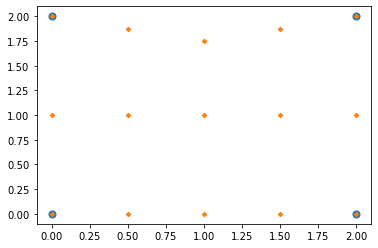

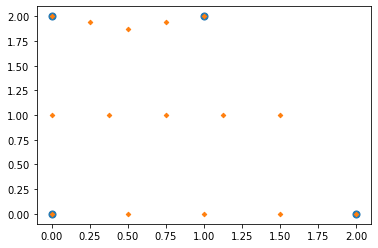

In [96]:
# Example 1: rectangle linear perimeter, 1D datum deformation
# define original mesh
pts_x = [0,2,2,0]
pts_y = [0,0,2,2]
nds_x = [0,2,2,0,1,2,0.5,1,1.50,0,1,1.5,0.5,0.5,1.5]
nds_y = [0,0,2,2,0,1,1.875,1.75,1.875,1,1,1,1,0,0]
orig_mesh = Mesh(pts_x, pts_y, nds_x, nds_y)

orig_mesh.plot_mesh(show_nodes=True)

# define image datums
pts_x = [0,2,1,0]
pts_y = [0,0,2,2]
img_mesh = Mesh(pts_x, pts_y)

img_mesh.gen_mesh(orig_mesh)
img_mesh.plot_mesh(show_nodes=True)